In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import nibabel as nib
from scipy import ndimage
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt


# Load Segmentation Datasets
fcd_dataset_paths = [
    os.path.join(os.getcwd(), "C:/Users/HP/Desktop/CCCNN/SORTED_WITH_FCD_FLAIR", x)
    for x in os.listdir("C:/Users/HP/Desktop/CCCNN/SORTED_WITH_FCD_FLAIR")
    if x.endswith(".nii")  # Filter only NIfTI files
]

roi_dataset_paths = [
    os.path.join(os.getcwd(), "C:/Users/HP/Desktop/CCCNN/ROI", x)
    for x in os.listdir("C:/Users/HP/Desktop/CCCNN/ROI")
    if x.endswith(".nii")  # Filter only NIfTI files
]


In [5]:

def process_segmentation_data(path, target_shape):
    segmentation_data = read_nifti_file(path)
    segmentation_data = resize_volume(segmentation_data, target_shape)
    segmentation_data = normalize(segmentation_data)
    return segmentation_data

def process_roi_data(path, target_shape, intensity_threshold=0.5):
    roi_data = read_nifti_file(path)
    roi_data = resize_volume(roi_data, target_shape)
    # Assuming intensity_threshold is the value to differentiate the colored part
    roi_mask = (roi_data > intensity_threshold).astype(np.float32)
    return roi_mask

def read_nifti_file(file_path):
    nifti_image = nib.load(file_path)
    nifti_data = nifti_image.get_fdata()
    return nifti_data

def resize_volume(volume, target_shape):
    current_shape = volume.shape
    zoom_factors = [target / current for target, current in zip(target_shape, current_shape)]
    resized_volume = ndimage.zoom(volume, zoom_factors, order=1)
    return resized_volume

def normalize(volume):
    mean_val = np.mean(volume)
    std_val = np.std(volume)
    normalized_volume = (volume - mean_val) / std_val
    return normalized_volume

# Assuming you have segmentation labels (masks) corresponding to FCD and ROI datasets
fcd_labels = np.ones((len(fcd_dataset_paths), 64, 64, 60, 1), dtype=np.float32)
roi_labels = np.zeros((len(roi_dataset_paths), 64, 64, 60, 1), dtype=np.float32)




target_shape = (64, 64, 60)

# Read and process the segmentation data
fcd_segmentation_data = np.array([process_segmentation_data(path, target_shape) for path in fcd_dataset_paths])
roi_segmentation_data = np.array([process_segmentation_data(path, target_shape) for path in roi_dataset_paths])







# Split data for training and validation
split_index_segmentation = int(0.7 * min(len(fcd_dataset_paths), len(roi_dataset_paths)))
x_train_segmentation = np.concatenate((fcd_segmentation_data[:split_index_segmentation], roi_segmentation_data[:split_index_segmentation]), axis=0)
y_train_segmentation = np.concatenate((fcd_labels[:split_index_segmentation], roi_labels[:split_index_segmentation]), axis=0)
x_val_segmentation = np.concatenate((fcd_segmentation_data[split_index_segmentation:], roi_segmentation_data[split_index_segmentation:]), axis=0)
y_val_segmentation = np.concatenate((fcd_labels[split_index_segmentation:], roi_labels[split_index_segmentation:]), axis=0)

# Data loaders for segmentation
segmentation_train_loader = tf.data.Dataset.from_tensor_slices((x_train_segmentation, y_train_segmentation))
segmentation_validation_loader = tf.data.Dataset.from_tensor_slices((x_val_segmentation, y_val_segmentation))
batch_size_segmentation = 1
segmentation_train_dataset = (
    segmentation_train_loader.shuffle(len(x_train_segmentation))
    .batch(batch_size_segmentation)
    .prefetch(2)
)

segmentation_validation_dataset = (
    segmentation_validation_loader.shuffle(len(x_val_segmentation))
    .batch(batch_size_segmentation)
    .prefetch(2)
)



In [6]:

import numpy as np
from scipy import ndimage
from sklearn.metrics import confusion_matrix, f1_score




def get_unet_model(input_shape=(64, 64, 60, 1)):  # Updated input shape
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = layers.Conv3D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    # Decoder
    conv2 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv2)
    up1 = layers.UpSampling3D(size=(2, 2, 2))(conv2)

    # Output
    output_segmentation = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(up1)

    model = models.Model(inputs, output_segmentation, name="3d_unet_segmentation")
    return model

# Create U-Net model for segmentation
seg_model = get_unet_model(input_shape=(64, 64, 60, 1))
seg_model.summary()


Model: "3d_unet_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 60, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 64, 64, 60, 64)    1792      
                                                                 
 conv3d_1 (Conv3D)           (None, 64, 64, 60, 64)    110656    
                                                                 
 max_pooling3d (MaxPooling3D  (None, 32, 32, 30, 64)   0         
 )                                                               
                                                                 
 conv3d_2 (Conv3D)           (None, 32, 32, 30, 128)   221312    
                                                                 
 conv3d_3 (Conv3D)           (None, 32, 32, 30, 128)   442496    
                                              

In [7]:


# Compile the segmentation model
seg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [8]:

# Assuming 'seg_checkpoint_cb' is your ModelCheckpoint callback
seg_checkpoint_cb = keras.callbacks.ModelCheckpoint("3d_segmentation_model.h5", save_best_only=True)


In [9]:

# Train the segmentation model
seg_model.fit(
    segmentation_train_dataset,
    validation_data=segmentation_validation_dataset,
    epochs=5,
    shuffle=True,
    verbose=2,
    callbacks=[seg_checkpoint_cb]
)

Epoch 1/5
106/106 - 500s - loss: 0.9954 - accuracy: 0.7224 - val_loss: 0.3404 - val_accuracy: 0.9954 - 500s/epoch - 5s/step
Epoch 2/5
106/106 - 397s - loss: 0.3324 - accuracy: 0.9985 - val_loss: 0.3244 - val_accuracy: 0.9982 - 397s/epoch - 4s/step
Epoch 3/5
106/106 - 406s - loss: 0.3169 - accuracy: 0.9994 - val_loss: 0.3088 - val_accuracy: 0.9991 - 406s/epoch - 4s/step
Epoch 4/5
106/106 - 428s - loss: 0.3016 - accuracy: 0.9998 - val_loss: 0.2938 - val_accuracy: 0.9996 - 428s/epoch - 4s/step
Epoch 5/5
106/106 - 435s - loss: 0.2870 - accuracy: 0.9999 - val_loss: 0.2795 - val_accuracy: 0.9998 - 435s/epoch - 4s/step


In [10]:

# Evaluate the model on the validation set
seg_model.evaluate(segmentation_validation_dataset)



48/48 [==============================] - 27s 560ms/step - loss: 0.2795 - accuracy: 0.9998


[0.2794892489910126, 0.9997694492340088]

In [11]:
#  print shapes after training
for inputs, targets in segmentation_validation_dataset.take(1):  
    predictions = seg_model.predict(inputs)
    print("Inputs shape:", inputs.shape)
    print("Targets shape:", targets.shape)
    print("Predictions shape:", predictions.shape)

1/1 [==============================] - 1s 779ms/step
Inputs shape: (1, 64, 64, 60)
Targets shape: (1, 64, 64, 60, 1)
Predictions shape: (1, 64, 64, 60, 1)


In [12]:

# Replace these paths with the actual paths to your specific MRI and ROI files
specific_mri_path = "C:/Users/HP/Desktop/CCCNN/SORTED_WITH_FCD_FLAIR/sub-00006_acq-tse3dvfl_FLAIR.nii"
specific_roi_path = "C:/Users/HP/Desktop/CCCNN/ROI/sub-00006_acq-tse3dvfl_FLAIR_roi.nii"

# Load specific MRI and ROI data
specific_mri_data = read_nifti_file(specific_mri_path)
specific_roi_data = read_nifti_file(specific_roi_path)

# Assuming you have a function read_nifti_file as before
def read_nifti_file(file_path):
    nifti_image = nib.load(file_path)
    nifti_data = nifti_image.get_fdata()
    return nifti_data


In [18]:
# Print the sizes
print("Original MRI size:", specific_mri_data.shape)
print("Predicted ROI size:", specific_roi_prediction.shape)


Original MRI size: (160, 256, 256)
Predicted ROI size: (1, 64, 64, 60, 1)


# CORRECT

Abnormality coordinates in original image (slice 163): [[  0   0]
 [  0   1]
 [  0   2]
 ...
 [159 253]
 [159 254]
 [159 255]]
Ground Truth coordinates in original image (slice 163): [[ 41 134]
 [ 42 134]
 [ 43 133]
 [ 43 134]
 [ 44 133]
 [ 44 134]
 [ 45 133]
 [ 45 134]
 [ 46 133]
 [ 46 134]
 [ 47 133]
 [ 48 132]
 [ 48 133]
 [ 49 132]
 [ 49 133]
 [ 50 131]
 [ 50 132]
 [ 50 133]
 [ 51 131]
 [ 51 132]
 [ 51 133]
 [ 52 128]
 [ 52 129]
 [ 52 130]
 [ 52 131]
 [ 52 132]
 [ 52 133]
 [ 53 128]
 [ 53 129]
 [ 53 130]
 [ 53 131]
 [ 53 132]
 [ 54 128]
 [ 54 129]
 [ 54 130]
 [ 54 131]
 [ 54 132]
 [ 55 128]
 [ 56 128]]


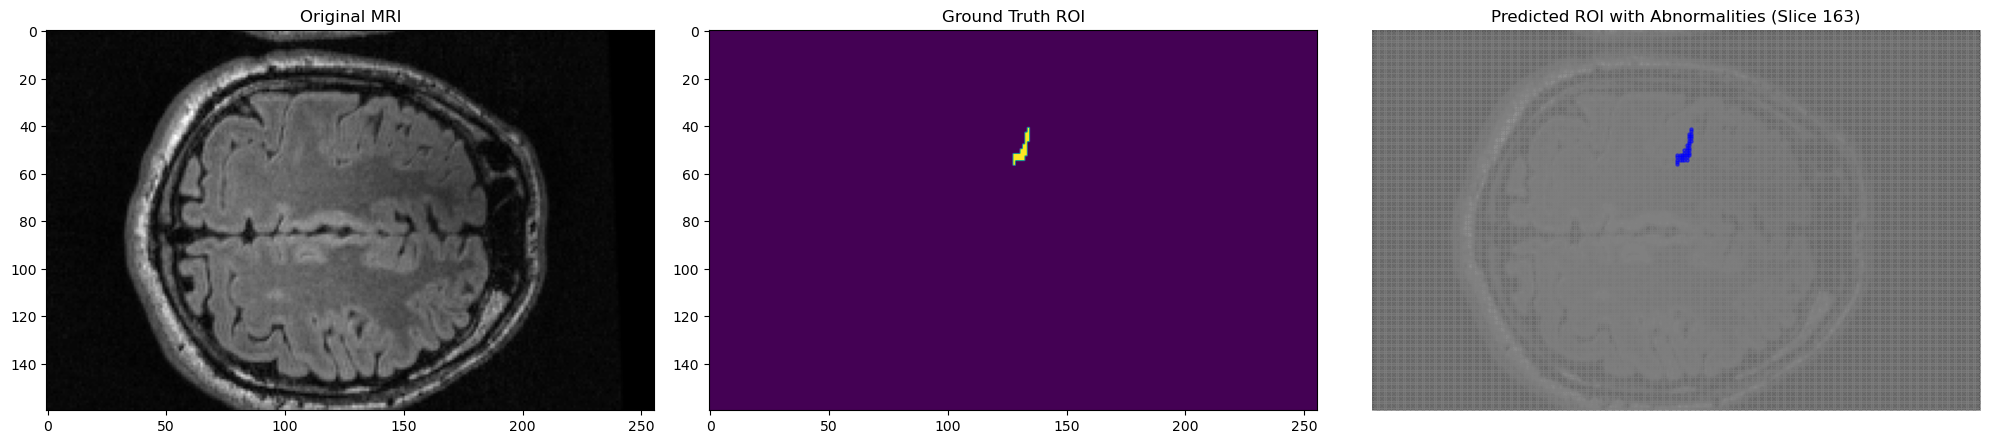

In [64]:
import matplotlib.pyplot as plt
from skimage.transform import resize  # Import the resize function

# Assuming specific_mri_data, specific_roi_data, and specific_roi_prediction are defined

# Select the slices where the ground truth mask is present
slices_with_mask = np.any(specific_roi_data > 0, axis=(0, 1))

# Display only slice 160 with a larger figure size
slice_index = 163
if slices_with_mask[slice_index]:
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(specific_mri_data[:, :, slice_index], cmap='gray')
    plt.title('Original MRI')

    plt.subplot(1, 3, 2)
    plt.imshow(specific_roi_data[:, :, slice_index], cmap='viridis', vmin=0, vmax=1)
    plt.title('Ground Truth ROI')

    plt.subplot(1, 3, 3)
    plt.imshow(specific_mri_data[:, :, slice_index], cmap='gray')

    # Use modulus to ensure the index is within bounds
    predicted_roi_slice_index = slice_index % specific_roi_prediction.shape[3]
    predicted_roi_slice = specific_roi_prediction[0, :, :, predicted_roi_slice_index, 0]

    # Resize ground truth ROI to match the size of the original MRI slice
    ground_truth_roi_slice_resized = resize(ground_truth_roi_slice, specific_mri_data[:, :, slice_index].shape)

    # Resize the predicted ROI to match the size of the original MRI slice
    predicted_roi_slice_resized = resize(predicted_roi_slice, specific_mri_data[:, :, slice_index].shape)

    # Check if the ground truth ROI differs from the predicted ROI
    difference_mask = np.abs(ground_truth_roi_slice_resized - predicted_roi_slice_resized) > 0.5  # Adjust the threshold based on your specific use case

    # Find the coordinates where the abnormality is present
    abnormality_coordinates = np.column_stack(np.where(difference_mask))

    # Find the coordinates where the ground truth coincides with the original image
    gt_coordinates = np.column_stack(np.where(specific_roi_data[:, :, slice_index] > 0))

    # Print the abnormality coordinates in the original image
    print(f"Abnormality coordinates in original image (slice {slice_index}): {abnormality_coordinates}")

    # Print the ground truth coordinates in the original image
    print(f"Ground Truth coordinates in original image (slice {slice_index}): {gt_coordinates}")

    # Overlay the abnormality regions with gray color and zoom out
    plt.scatter(abnormality_coordinates[:, 1], abnormality_coordinates[:, 0], c='gray', s=5, alpha=0.5)  # Flip coordinates for imshow

    # Overlay the coinciding ground truth regions with blue color and zoom out
    plt.scatter(gt_coordinates[:, 1], gt_coordinates[:, 0], c='blue', s=5, alpha=0.5)  # Flip coordinates for imshow
    
    plt.axis('off')

    # Overlay the predicted ROI regions with red color and zoom out
    plt.imshow(np.ma.masked_array(predicted_roi_slice_resized, mask=difference_mask), cmap='Reds', alpha=0.3)

    plt.title(f'Predicted ROI with Abnormalities (Slice {slice_index})')

    plt.tight_layout()
    plt.show()
